In [132]:
import os
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized2


# Zodiacal Density plot

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from astropy.coordinates import solar_system_ephemeris, get_body, get_sun, HeliocentricTrueEcliptic
from astropy.time import Time, TimeDelta

from zodipy import tabulate_density

In [3]:
N = 200
x = np.linspace(-2.5, 2.5, N)  # x-plane
y = np.linspace(-2.5, 2.5, N)  # y-plane
z = np.linspace(-2.5, 2.5, N)  # z-plane

In [4]:
grid = np.asarray(np.meshgrid(x, y, z))
density_grid = tabulate_density(grid, model="dirbe")
density_grid = density_grid.sum(axis=0)  # Sum over all components

In [5]:
start_time = Time("1990-09-22 23:22")
dt = TimeDelta(15, format="jd")
time_range = start_time + dt * np.arange(0, 5*365//30+1)

earth_location = get_body('earth', time_range).transform_to(HeliocentricTrueEcliptic()).cartesian.xyz.to('AU')

In [6]:
planets = ['mercury', 'venus', 'mars']
sun_location = get_sun(time_range).cartesian.xyz.to('AU')
planet_locations = np.stack([get_body(p, time_range).transform_to(HeliocentricTrueEcliptic()).cartesian.xyz.to('AU') for p in planets])

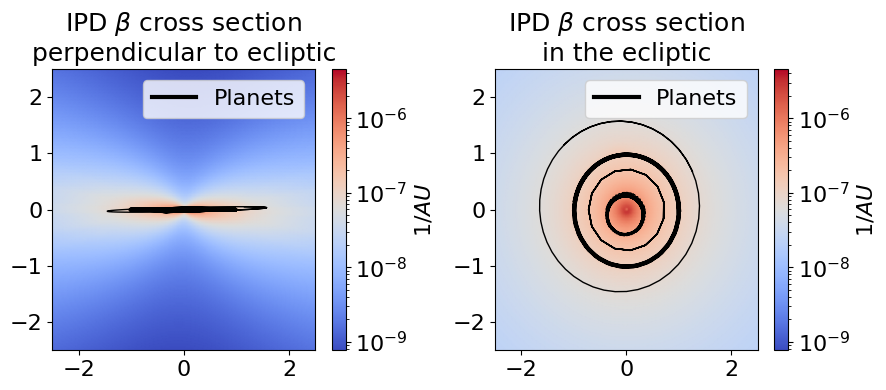

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
plt1 = ax1.pcolormesh(
    x,
    y,
    density_grid[N // 2].T,  # cross section in the yz-plane
    cmap="coolwarm",
    norm=LogNorm(vmin=density_grid.min(), vmax=density_grid.max()),
    shading="gouraud",
    rasterized=True
)
ax1.plot(earth_location[1, :], earth_location[2, :], "k", lw=3, label='Planets')
for planet in planet_locations:
    ax1.plot(planet[1, :], planet[2, :], "k", lw=1, label=None)
cbar = fig.colorbar(plt1, ax=ax1)
cbar.set_label("$1/AU$", fontsize=16)
cbar.ax.yaxis.set_tick_params(labelsize=16)
ax1.set_title("IPD $\\beta$ cross section\nperpendicular to ecliptic", fontsize=18)
# ax1.set_xlabel("X (AU)", fontsize=16)
# ax1.set_ylabel("Z (AU)", fontsize=16)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.legend(fontsize=16)
# ax1.axis('equal')

plt2 = ax2.pcolormesh(
    y,
    z,
    density_grid[:, :, N // 2].T,  # cross section in the yz-plane
    cmap="coolwarm",
    norm=LogNorm(vmin=density_grid.min(), vmax=density_grid.max()),
    shading="gouraud",
    rasterized=True
)
ax2.plot(earth_location[0, :], earth_location[1, :], "k", lw=3, label='Planets')
for planet in planet_locations:
    ax2.plot(planet[0, :], planet[1, :], "k", lw=1, label=None)
cbar = plt.colorbar(plt2, ax=ax2)
cbar.set_label("$1/AU$", fontsize=16)
cbar.ax.yaxis.set_tick_params(labelsize=16)
ax2.set_title("IPD $\\beta$ cross section\nin the ecliptic", fontsize=18)
# ax2.set_xlabel("X (AU)", fontsize=16)
# ax2.set_ylabel("Y (AU)", fontsize=16)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.legend(fontsize=16)
# ax2.axis('equal')
fig.tight_layout()
plt.savefig('outputs/dust_density.pdf', format='pdf')
plt.show()

# Zodiacal light plots

In [1]:
# zodiacal light image creation
import astropy.units as u
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time
from scipy.interpolate import griddata

from zodipy import Zodipy
from zodipol.visualization.skymap_plots import plot_skymap, plot_skymap_multicolor

ImportError: No module named 'astropy'

In [2]:
model = Zodipy("dirbe", solar_cut=30 * u.deg, extrapolate=True, parallel=False)
nside = 56

binned_emission1250 = model.get_binned_emission_pix(
    1.25 * u.micron,
    pixels=np.arange(hp.nside2npix(nside)),
    nside=nside,
    obs_time=Time("2022-06-14"),
    obs="earth",
)

binned_emission2200 = model.get_binned_emission_pix(
    2.2 * u.micron,
    pixels=np.arange(hp.nside2npix(nside)),
    nside=nside,
    obs_time=Time("2022-06-14"),
    obs="earth",
)

binned_emission3500 = model.get_binned_emission_pix(
    3.5 * u.micron,
    pixels=np.arange(hp.nside2npix(nside)),
    nside=nside,
    obs_time=Time("2022-06-14"),
    obs="earth",
)

In [4]:
emission = np.stack((binned_emission3500, binned_emission2200, binned_emission1250), axis=-1)
emission.shape

(37632, 3)

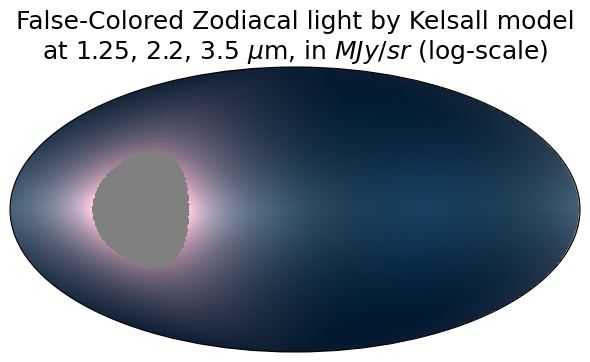

In [8]:
title = 'False-Colored Zodiacal light by Kelsall model\nat 1.25, 2.2, 3.5 $\mu$m, in $MJy/sr$ (log-scale)'
plot_skymap_multicolor(emission.value, log=True, saveto='../outputs/kelsall_zodiacal_light.pdf', title=title)

# Colored ISL plot

In [1]:
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized2


In [46]:
from zodipol.background_radiation import IntegratedStarlight
from zodipol.imager.imager import Imager
from zodipol.visualization.skymap_plots import plot_skymap_multicolor
import astropy.units as u
import numpy as np
from astropy.constants import c

In [35]:
# magics
%reload_ext autoreload
%autoreload 2

In [4]:
isl = IntegratedStarlight.load('saved_models/skymap_flux.npz')
imager = Imager()

In [29]:
wavelength = np.linspace(300, 700, 10)
freq = (wavelength.tolist() * u.nm).to('Hz', equivalencies=u.spectral())

isl_interp = isl.interpolate_freq(freq)

jacobian = -c / freq ** 2
isl_interp_freq = (isl_interp * jacobian).to('W / m^2 sr Hz')

In [30]:
isl_colors = []
for channel in imager.get_pixel_colors():
    response = imager.get_camera_response(wavelength, channel)
    isl_channel = imager.intensity_to_number_of_electrons(isl_interp_freq, frequency=freq, weights=response)
    isl_colors.append(isl_channel)

In [31]:
isl_colors_arr = np.stack(isl_colors, axis=-1)

In [8]:
isl_colors_arr.shape

(786432, 3)

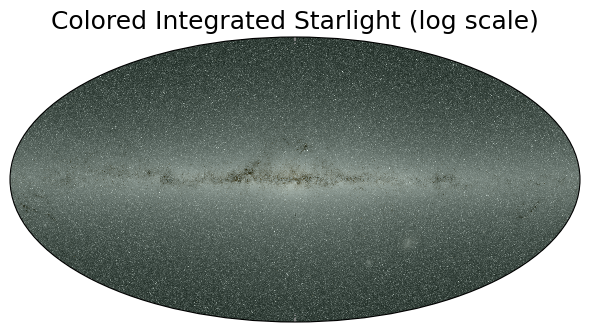

In [49]:
plot_skymap_multicolor(isl_colors_arr.value, log=True, title='Colored Integrated Starlight (log scale)', saveto='outputs/isl_fullsky.pdf')